In [1]:
# conda install -c conda-forge lightgbm
# conda install -c conda-forge xgboost

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### 1. 결측치 제거
#### 1) 주택소유상태

주택소유상태에서 'ANY'는 단 하나 밖에 없는 값이므로

해당 row를 제거

In [6]:
df = pd.read_csv('train.csv')

df = df.drop(index=df[df['주택소유상태'] == 'ANY'].index)
df.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


#### 2) 근로기간

In [7]:
def year_encoder(x):
    output = x.replace('years', '')
    output = output.replace('year', '')
    output = output.replace('+', '')
    output = output.replace('<', '')
    output = output.replace('Unknown', '-1').strip()
    output = int(output)

    return output

In [8]:
df['근로기간'] = df['근로기간'].apply(year_encoder)

In [9]:
df_known = df[df['근로기간'] != -1]
df_unknown = df[df['근로기간'] == -1]


In [10]:
df_known.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
5,TRAIN_00005,4800000,36 months,10,RENT,84000000,13.78,30,휴가,0,240216,55428.0,0.0,0.0,A


<AxesSubplot:xlabel='부채_대비_소득_비율', ylabel='Count'>

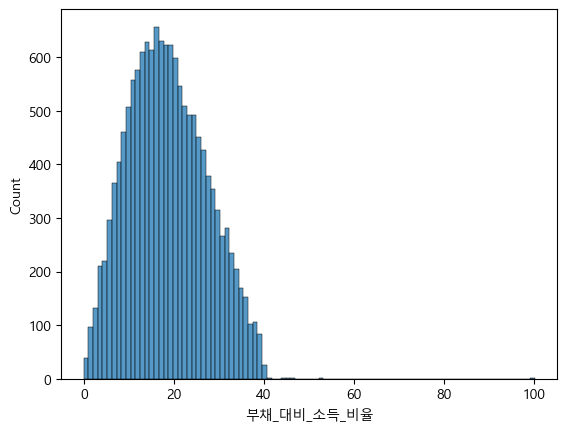

In [11]:
sns.histplot(df_known[df_known['근로기간'] == 1]['부채_대비_소득_비율'])

<AxesSubplot:xlabel='부채_대비_소득_비율', ylabel='Count'>

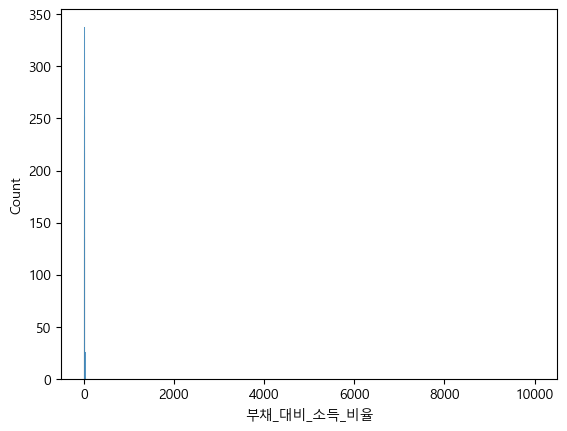

In [12]:
sns.histplot(df_unknown['부채_대비_소득_비율'])

In [13]:
unknown_annual_income = df_unknown['연간소득'].median()
unknown_ratio = df_unknown['부채_대비_소득_비율'].median()
unknown_house = (df_unknown['주택소유상태'].value_counts() / df_unknown['주택소유상태'].value_counts().sum()).sort_index()

In [14]:
work_year = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


for year in work_year:
    
    
    temp = df_known[df_known['근로기간'] == year]
    
    
    annual_income = temp['연간소득'].median()
    ratio = temp['부채_대비_소득_비율'].median()
    house = (temp['주택소유상태'].value_counts() / temp['주택소유상태'].value_counts().sum()).sort_index()
        
    se_annaul_income = (annual_income - unknown_annual_income) ** 2
    se_ratio = (ratio - unknown_ratio) ** 2
    se_house = ((house - unknown_house) ** 2).sum()
    
    sse_list = [se_annaul_income, se_ratio, se_house]
    
    print(f'{year} year sse : {np.sqrt(sum(sse_list))}')

1 year sse : 18000000.00000016
2 year sse : 22546200.000000134
3 year sse : 22800000.000000104
4 year sse : 24000000.00000009
5 year sse : 24000000.000000082
6 year sse : 24000000.00000005
7 year sse : 25200000.00000005
8 year sse : 26829000.000000045
9 year sse : 25429200.000000034
10 year sse : 34800000.00000003


In [15]:
df_unknown['근로기간'] = 1
df_unknown['근로기간'].value_counts()

1    5671
Name: 근로기간, dtype: int64

In [16]:
df_simple = pd.concat([df_known, df_unknown], axis=0).reset_index(drop=True)

### 이상치 제거법

#### 1) 사분위수 - 유실 데이터가 너무 많아서 기각
#### 2) EDS 사용하기

In [19]:
numeric_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '근로기간']
category_col = ['대출기간', '주택소유상태', '대출목적']

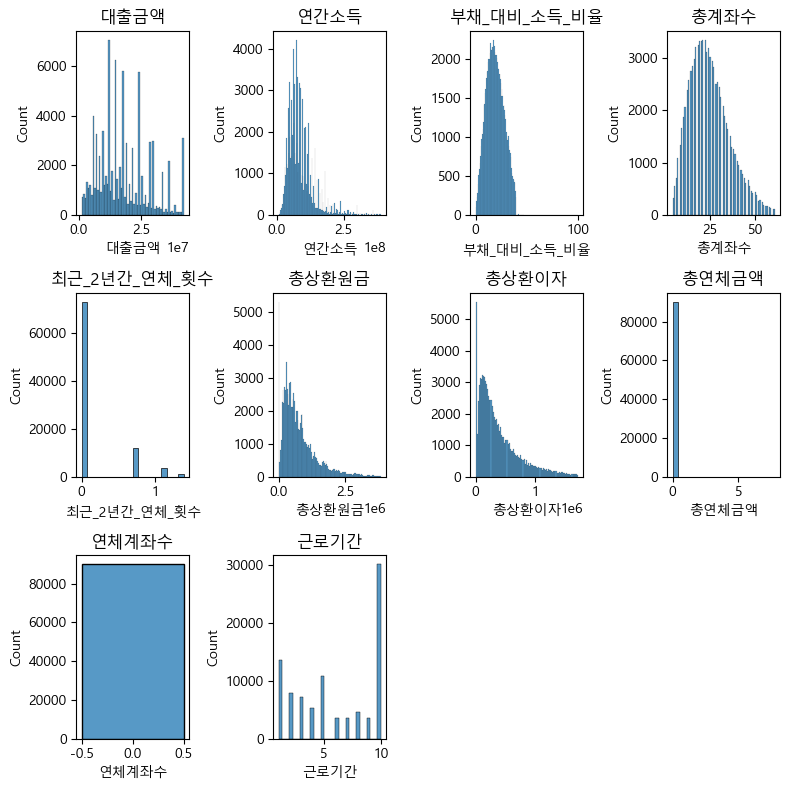

In [84]:
def get_3_hist(data:pd.DataFrame, columns:list):
    
    plt.figure(figsize=(8, 8))

    for i, col in enumerate(columns):
        # 서브플롯 위치 설정
        plt.subplot(3, 4, i + 1)
        # 히스토그램 그리기
        sns.histplot(data[col])
        plt.title(col)

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()

get_3_hist(df_simple, numeric_col)

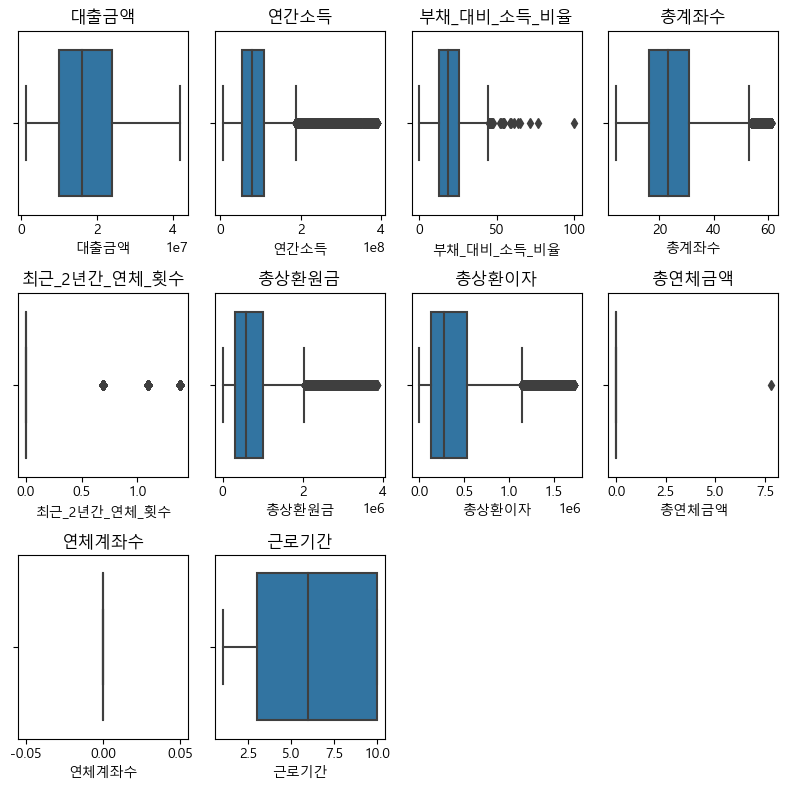

In [90]:
def get_3_box(data:pd.DataFrame, columns:list):
    
    plt.figure(figsize=(8, 8))

    for i, col in enumerate(columns):
        # 서브플롯 위치 설정
        plt.subplot(3, 4, i + 1)
        # 히스토그램 그리기
        sns.boxplot(data[col])
        plt.title(col)

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()

get_3_box(df_simple, numeric_col)

In [20]:
df = df_simple

In [21]:
def remove_outliers(train_df, col, threshold=3):
    mean = np.mean(train_df[col])
    std_dev = np.std(train_df[col])
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
    train_df= train_df[(train_df[col] >= lower_bound) & (train_df[col] <= upper_bound)]
    return train_df

for col in numeric_col:
    df = remove_outliers(df, col, threshold=3)

In [22]:
log_processing = ['최근_2년간_연체_횟수', '총연체금액']

for col in log_processing:
    df[col] = np.log1p(df[col])

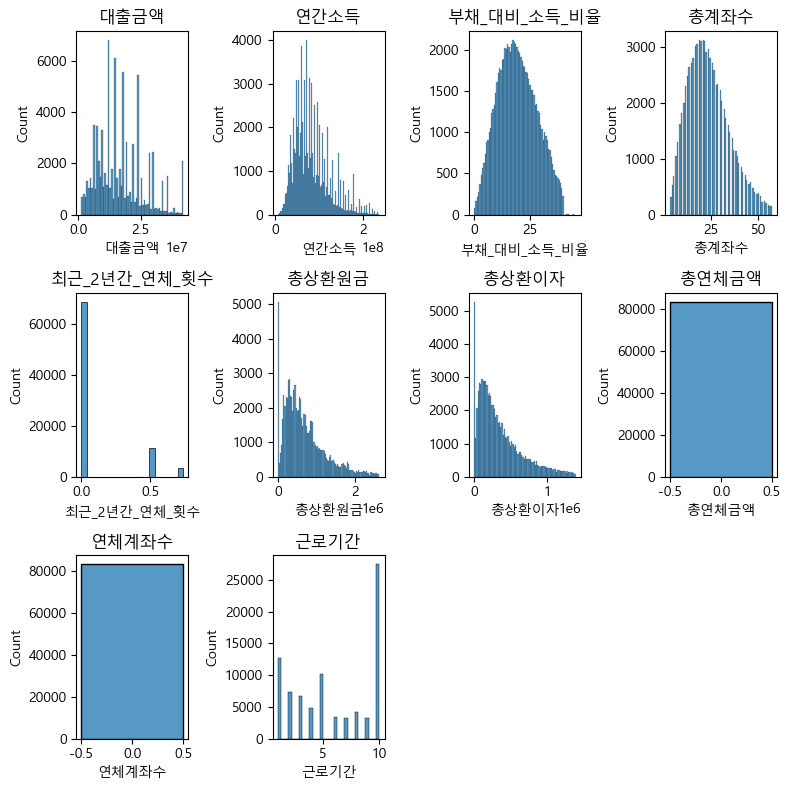

In [91]:
get_3_hist(df, numeric_col)

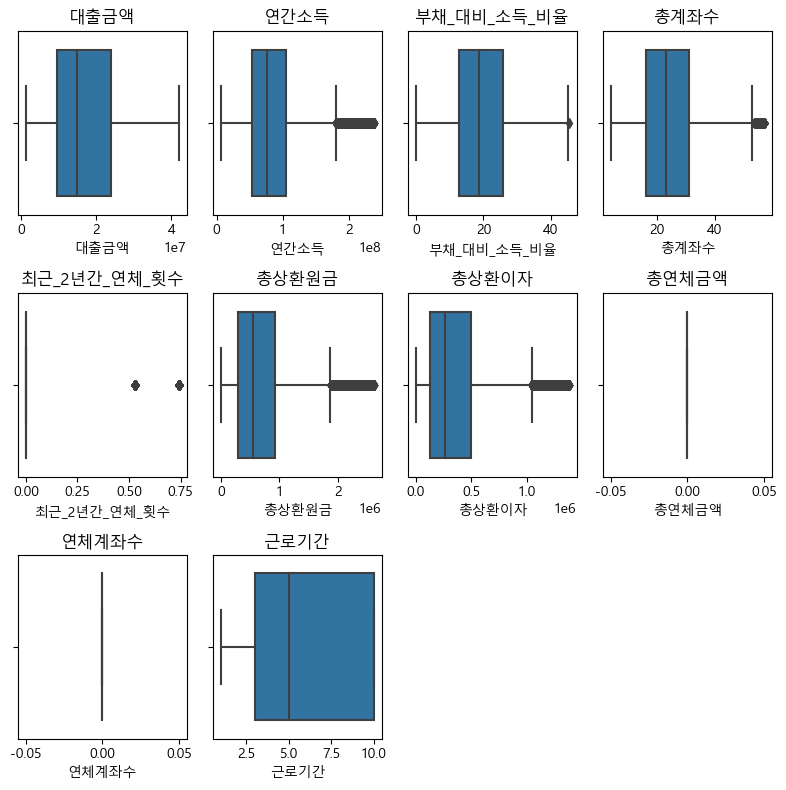

In [92]:
get_3_box(df, numeric_col)

### 3. 인코딩, 스케일링

#### 1) 스캐일링

numeric_col 컬럼 중에서 히스토그램의 개형을 토대로

sc_col = ['최근_2년간_연체_횟수', '총연체금액', '연체계좌수']

mm_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '근로기간']

위와 같이 스캐일링 방법을 정함


In [23]:
from sklearn.model_selection import train_test_split

X = df.drop(['ID', '대출등급'], axis=1)
y = df[['대출등급']]

print(X.shape, y.shape)

(90171, 13) (90171, 1)


In [24]:
def numeric_scaler(X):
    
    sc_col = ['최근_2년간_연체_횟수', '총연체금액', '연체계좌수']
    mm_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자']
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    sc = StandardScaler()
    mm = MinMaxScaler()
    
    X[sc_col] = sc.fit_transform(X[sc_col])
    X[mm_col] = mm.fit_transform(X[mm_col])
    
    return X

X = numeric_scaler(X)



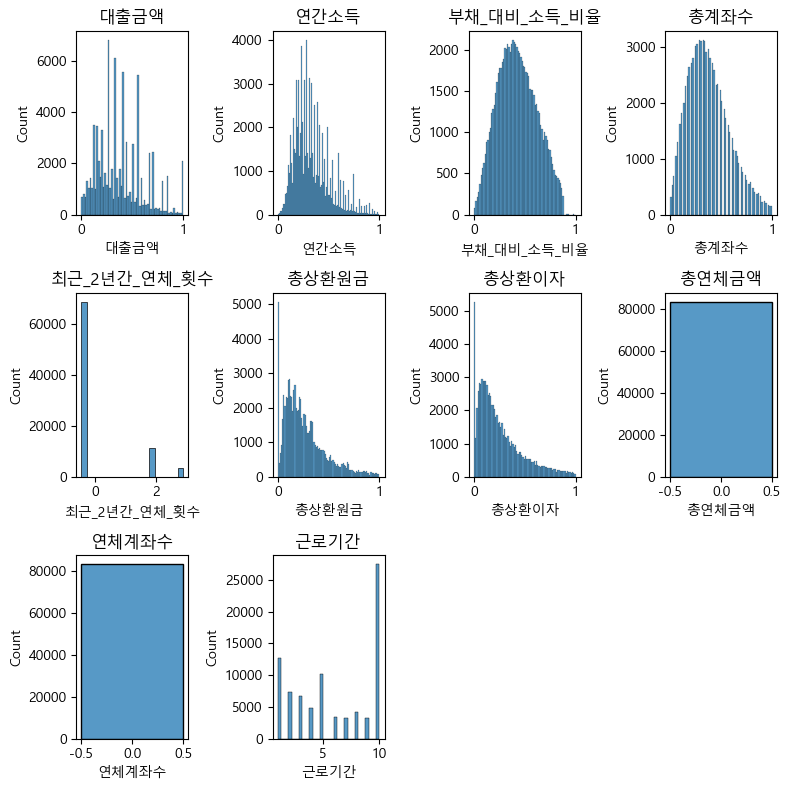

In [95]:
get_3_hist(X, numeric_col)

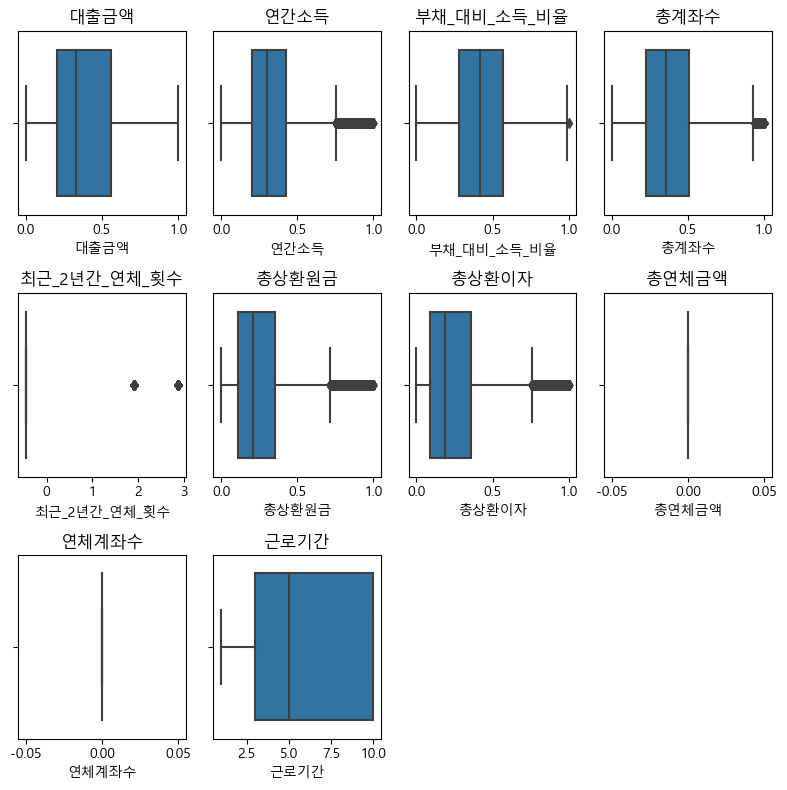

In [96]:
get_3_box(X, numeric_col)

#### 2) 인코딩

category_col = ['대출기간', '주택소유상태', '대출목적'] 에서

우위를 따질 컬럼은 없어 보이기에 onehot 인코딩으로 통일

종속변수 y, 대출등급은 Label 인코딩을 사용

In [25]:
def category_encoder(X:pd.DataFrame):
     X_dummies = pd.get_dummies(X[category_col])
     
     X = pd.concat([X, X_dummies], axis=1)
     
     return X, X_dummies.columns.to_list()

X, dummies_col = category_encoder(X)

In [26]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y['대출등급'])


y['대출등급'] = le.transform(y['대출등급'])

### 4. 파생변수 만들기

대출등급이 높을수록 아래 요소들의 비중이 높아졌다

특히 대출 기간은 최하등급에서는 단기보다 장기의 비율이 더 높았다

이를 토대로 파생변수 제작 시 대출기간 컬럼의 비중을 높일 예정

- 대출기간 : 단기
- 주택상태 : 전세
- 대출목적 : 부채통합

In [28]:
## 예시

for col in category_col:
    print(col)
    display(df[df['대출등급'] == "A"][col].value_counts() / df[df['대출등급'] == "A"][col].value_counts().sum())
    print('----------------------------------')


대출기간


 36 months    0.950546
 60 months    0.049454
Name: 대출기간, dtype: float64

----------------------------------
주택소유상태


MORTGAGE    0.572226
RENT        0.317138
OWN         0.110635
Name: 주택소유상태, dtype: float64

----------------------------------
대출목적


부채 통합     0.479213
신용 카드     0.384028
주택 개선     0.072288
주요 구매     0.021966
기타        0.021097
자동차       0.010176
의료        0.006329
휴가        0.002482
소규모 사업    0.001117
이사        0.000745
주택        0.000496
재생 에너지    0.000062
Name: 대출목적, dtype: float64

----------------------------------


### 5. 오버샘플링

확인 결과 대출 등급이 낮은 데이터가 현저히 적다

오버샘플링을 통해 보완한다

오버샘플링을 위해 인코딩 먼저 하고 스캐일링을 진행

이후 파생변수를 생성한다

In [27]:
X = df.drop(['ID', '대출등급'], axis=1)
y = df[['대출등급']]

In [28]:
y.value_counts()

대출등급
B       27556
C       26183
A       16116
D       12201
E        6345
F        1484
G         286
dtype: int64

In [29]:
X, dummies_col = category_encoder(X)
X = X.drop(columns=category_col)

In [30]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y['대출등급'])


y['대출등급'] = le.transform(y['대출등급'])

In [31]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

X, y = sm.fit_resample(X, y)

In [196]:
y.value_counts()

대출등급
0       27556
1       27556
2       27556
3       27556
4       27556
5       27556
6       27556
dtype: int64

In [32]:
X = numeric_scaler(X)

In [33]:
X['dv_category'] = ((2 * X['대출기간_ 36 months']) + X['주택소유상태_MORTGAGE'] + X['대출목적_부채 통합']) / 4  # 대출 등급별 category_col 분포 특성을 반영
X['dv_ratio'] = (X['총상환원금']) / (X['대출금액'] + 1)                                                       # 대출금액 대비 총상환원금(0인 값 처리를 위해 +1)
X['dv_short_ability'] = (X['연간소득'] / 12) - (X['대출금액'] / 36)                                           # 단기상환능력                                   
X['dv_left_debt'] = X['대출금액'] - X['총상환원금'] - X['총상환이자']                                          # 잔여대출금
X['dv_rent_p'] = X['총상환원금'] / (X['대출금액'] + 1)                                                        # 대출 금액 대비 총상환금 비율
X['dv_rent_i'] = X['총상환이자'] / (X['대출금액'] + 1)


In [34]:
colcol = ['dv_ratio', 'dv_short_ability', 'dv_left_debt', 'dv_rent_p', 'dv_rent_i']

for col in colcol:
    print(np.isnan(X[col]).sum(), np.isinf(X[col]).sum())

0 0
0 0
0 0
0 0
0 0


In [35]:
numeric_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '근로기간']
category_col = ['대출기간', '주택소유상태', '대출목적']

In [36]:
dummies_col = dummies_col + ['dv_category']
numeric_col = numeric_col + ['dv_ratio', 'dv_short_ability', 'dv_left_debt', 'dv_rent_p', 'dv_rent_i']

In [37]:
dummies_col

['대출기간_ 36 months',
 '대출기간_ 60 months',
 '주택소유상태_MORTGAGE',
 '주택소유상태_OWN',
 '주택소유상태_RENT',
 '대출목적_기타',
 '대출목적_부채 통합',
 '대출목적_소규모 사업',
 '대출목적_신용 카드',
 '대출목적_의료',
 '대출목적_이사',
 '대출목적_자동차',
 '대출목적_재생 에너지',
 '대출목적_주요 구매',
 '대출목적_주택',
 '대출목적_주택 개선',
 '대출목적_휴가',
 'dv_category']

In [38]:
numeric_col

['대출금액',
 '연간소득',
 '부채_대비_소득_비율',
 '총계좌수',
 '최근_2년간_연체_횟수',
 '총상환원금',
 '총상환이자',
 '총연체금액',
 '연체계좌수',
 '근로기간',
 'dv_ratio',
 'dv_short_ability',
 'dv_left_debt',
 'dv_rent_p',
 'dv_rent_i']

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

In [40]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(154313, 33) (38579, 33) (154313, 1) (38579, 1)


### 6. 모델링

여러 모델을 돌려보고 점수 잘 나오는 모델로 선정

In [41]:
def get_score(train:pd.DataFrame,  test:pd.DataFrame, x_var_list:list):
    
    X_train = train 
    X_test = test

    X_train = X_train[x_var_list]
    X_test = X_test[x_var_list]
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from sklearn.metrics import f1_score, accuracy_score
    
    logit = LogisticRegression()
    decision = DecisionTreeClassifier(random_state=42)
    rfc = RandomForestClassifier(random_state=42)
    gbc = GradientBoostingClassifier(random_state=42)
    xgb = XGBClassifier(random_state=42)
    light = LGBMClassifier(random_state=42)
    
    logit.fit(X_train, y_train)
    decision.fit(X_train, y_train)
    rfc.fit(X_train, y_train)
    gbc.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    light.fit(X_train, y_train)
    
    y_pred_train = logit.predict(X_train)
    y_pred_test = logit.predict(X_test)
    
    result_logit = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = decision.predict(X_train)
    y_pred_test = decision.predict(X_test)
    
    result_decision = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = rfc.predict(X_train)
    y_pred_test = rfc.predict(X_test)
    
    result_rfc = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = gbc.predict(X_train)
    y_pred_test = gbc.predict(X_test)
    
    result_gbc = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    
    result_xgb = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = light.predict(X_train)
    y_pred_test = light.predict(X_test)
    
    result_light = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    print('로지스틱')
    display(result_logit.round(2))
    print()
    print('의사결정나무')
    display(result_decision.round(2))
    print()
    print('랜덤포레스트')
    display(result_rfc.round(2))
    print()
    print('그라디언트 부스팅')
    display(result_gbc.round(2))
    print()
    print('XG 부스팅')
    display(result_xgb.round(2))
    print()
    print('Light GBM')
    display(result_light.round(2))


로지스틱
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>acc</th>
      <th>f1_score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>train</th>
      <td>0.52</td>
      <td>0.51</td>
    </tr>
    <tr>
      <th>test</th>
      <td>0.52</td>
      <td>0.51</td>
    </tr>
  </tbody>
</table>
</div>

의사결정나무
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>acc</th>
      <th>f1_score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>train</th>
      <td>1.00</td>
      <td>1.00</td>
    </tr>
    <tr>
      <th>test</th>
      <td>0.86</td>
      <td>0.86</td>
    </tr>
  </tbody>
</table>
</div>

랜덤포레스트
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>acc</th>
      <th>f1_score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>train</th>
      <td>1.00</td>
      <td>1.00</td>
    </tr>
    <tr>
      <th>test</th>
      <td>0.91</td>
      <td>0.91</td>
    </tr>
  </tbody>
</table>
</div>

그라디언트 부스팅
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>acc</th>
      <th>f1_score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>train</th>
      <td>0.75</td>
      <td>0.75</td>
    </tr>
    <tr>
      <th>test</th>
      <td>0.74</td>
      <td>0.74</td>
    </tr>
  </tbody>
</table>
</div>

XG 부스팅
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>acc</th>
      <th>f1_score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>train</th>
      <td>0.93</td>
      <td>0.93</td>
    </tr>
    <tr>
      <th>test</th>
      <td>0.90</td>
      <td>0.90</td>
    </tr>
  </tbody>
</table>
</div>

Light GBM
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>acc</th>
      <th>f1_score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>train</th>
      <td>0.90</td>
      <td>0.90</td>
    </tr>
    <tr>
      <th>test</th>
      <td>0.88</td>
      <td>0.88</td>
    </tr>
  </tbody>
</table>
</div>

In [206]:
# get_score(X_train, X_val, dummies_col + numeric_col)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2913
[LightGBM] [Info] Number of data points in the train set: 154313, number of used features: 31
[LightGBM] [Info] Start training from score -1.945897
[LightGBM] [Info] Start training from score -1.945897
[LightGBM] [Info] Start training from score -1.945897
[LightGBM] [Info] Start training from score -1.945943
[LightGBM] [Info] Start training from score -1.945897
[LightGBM] [Info] Start training from score -1.945897
[LightGBM] [Info] Start training from score -1.945943
로지스틱


,acc,f1_score
train,0.51,0.5
test,0.51,0.5



의사결정나무


,acc,f1_score
train,1.00,1.00
test,0.86,0.85



랜덤포레스트


,acc,f1_score
train,1.00,1.00
test,0.91,0.91



그라디언트 부스팅


,acc,f1_score
train,0.74,0.74
test,0.73,0.73



XG 부스팅


,acc,f1_score
train,0.93,0.93
test,0.90,0.90



Light GBM


,acc,f1_score
train,0.89,0.89
test,0.88,0.88


In [ ]:
numeric_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
category_col = ['대출기간', '주택소유상태', '대출목적', '근로기간']

#### 돌려본 결과 XGBOOST로 결정

In [42]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score



xgb = XGBClassifier(random_state=42)
xgb.fit(X_train[dummies_col + numeric_col], y_train)
    
y_pred_train = xgb.predict(X_train[dummies_col + numeric_col])
y_pred_val = xgb.predict(X_val[dummies_col + numeric_col])
    
result_xgb = pd.DataFrame(data={'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_val)],
                                'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_val, average='macro')]},
                          index=['train','test'])
    
display(result_xgb.round(2))

,acc,f1_score
train,0.93,0.93
test,0.90,0.90


### 7. 평가

In [43]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_val, y_pred_val)
confusion

array([[5173,  304,   24,    5,    4,    1,    0],
       [ 297, 4818,  373,   17,    3,    2,    1],
       [  51,  322, 4882,  221,   32,    1,    2],
       [  28,   49,  278, 4522,  576,   48,   11],
       [   8,   18,   59,  603, 4565,  229,   29],
       [   1,    8,   18,   69,  162, 5147,  106],
       [   0,    0,    1,    5,    1,   15, 5490]], dtype=int64)

#### 1) 성능

heatmap에서 확인한 결과 중위권 등급 색이 옅음 - 중위권 등급을 잘 분류하지 못 함

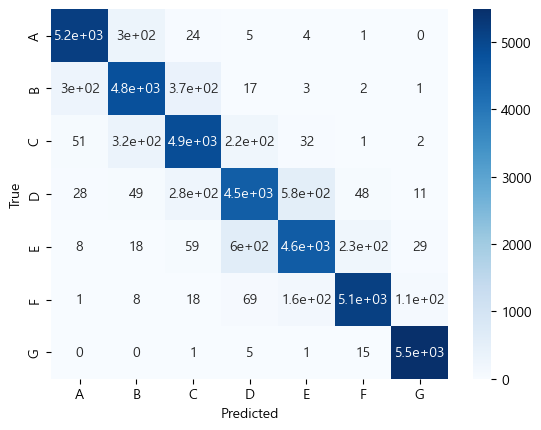

In [45]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

sns.heatmap(confusion, cmap='Blues',annot=True ,xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### 2) 중요도

- shap value는 다중분류에서 사용하는 법을 찾는 중
- feature importances를 통해 각 컬럼의 중요도를 산출

In [51]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_val)

In [53]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

for i in range(len(labels)):
    shap.plots.force(explainer.expected_value[i], shap_values[i])
    plt.title(f'{labels[i]}')

MemoryError: Unable to allocate 11.1 GiB for an array with shape (38579, 38579) and data type float64

In [48]:
feat_imp = xgb.feature_importances_

In [49]:
result = pd.DataFrame(data=feat_imp, index=X_train.columns, columns=['feat_imps'])

In [50]:
result = pd.DataFrame(result['feat_imps'].sort_values(ascending=False))

In [51]:
result

,feat_imps
대출금액,0.289121
대출목적_소규모 사업,0.095412
총연체금액,0.094282
부채_대비_소득_비율,0.058474
dv_rent_i,0.053073
대출목적_기타,0.043110
근로기간,0.039084
대출목적_주요 구매,0.038615
dv_ratio,0.037649
최근_2년간_연체_횟수,0.034432


<AxesSubplot:xlabel='feat_imps'>

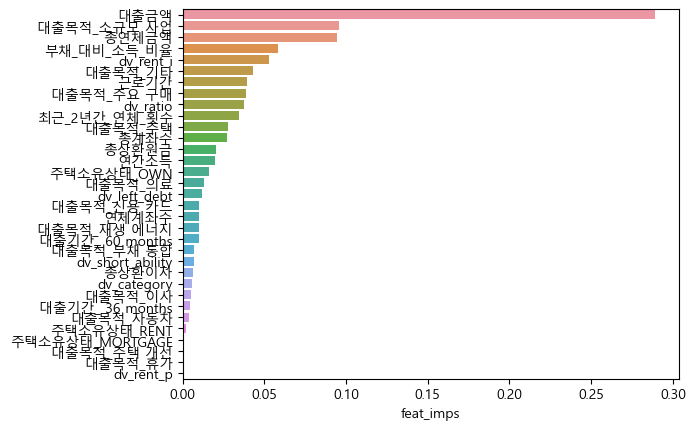

In [54]:
sns.barplot(data=result, x='feat_imps', y=result.index, orient='h')